### Relevante pakker

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

Merk: ChatGPT har blitt brukt for å få hjelp til å skrive deler av denne koden.

### Rense dataene

In [2]:
df = pd.read_csv("lego.population.csv", sep = ",", encoding = "latin1")

# # Clean the 'Theme' column, remove special characters
# df['Theme'] = df['Theme'].astype(str)
# df['Theme'] = df['Theme'].str.replace(r'[^a-zA-Z0-9\s-]', '', regex=True)

# # Clean the 'Price' column
# df['Price'] = df['Price'].str.replace('\$', '', regex = True)

# # Filter out and drop rows where 'Theme' is 'DUPLO'
# #df = df[df['Theme'] != 'DUPLO']

# Filter out and drop rows with certain 'Ages' values
df = df[df['Ages'] != 'Ages_NA']
df = df[df['Ages'] != 'NaN']

# Remove any leading/trailing whitespace from "Ages", and then remove 1 1/2 from Ages
df['Ages'] = df['Ages'].str.strip()
df = df[df['Ages'] != 'Ages_1½']  

# Trim Ages enstries to only keep numbers
df['Ages'] = df['Ages'].str.replace('Ages_', '').str.replace('+', '').str.replace('-.*', '')

# Convert age strings to int
df['Ages'] = pd.to_numeric(df['Ages'], errors='coerce').fillna(0).astype(int)

# Drop every age less than 3 years old
df = df[df['Ages'] > 3]

df

,Item_Number,Set_Name,Theme,Pieces,Price,Amazon_Price,Year,Ages,Pages,Minifigures,Packaging,Weight,Unique_Pieces,Availability,Size
0,41916,Extra Dots - Series 2,DOTS,109.0,$3.99,$3.44,2020.0,6,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
1,41908,Extra Dots - Series 1,DOTS,109.0,$3.99,$3.99,2020.0,6,NaN,NaN,Foil pack,NaN,6.0,Retail,Small
2,11006,Creative Blue Bricks,Classic,52.0,$4.99,$4.93,2020.0,4,37.0,NaN,Box,NaN,28.0,Retail,Small
3,11007,Creative Green Bricks,Classic,60.0,$4.99,$4.93,2020.0,4,37.0,NaN,Box,NaN,36.0,Retail,Small
4,41901,Funky Animals Bracelet,DOTS,33.0,$4.99,$4.99,2020.0,6,NaN,NaN,Foil pack,NaN,10.0,Retail,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,45678,SPIKE Prime Set,LEGO® Education,528.0,$329.95,NaN,2020.0,10,NaN,2.0,NaN,NaN,108.0,NaN,Small
1300,71367,Mario's House & Yoshi,LEGO® Super Mario,205.0,$29.99,NaN,2020.0,6,NaN,2.0,Box,NaN,114.0,Retail,Small
1301,71368,Toad's Treasure Hunt,LEGO® Super Mario,464.0,$69.99,NaN,2020.0,8,NaN,4.0,Box,NaN,195.0,Retail,Small
1302,71369,Bowser's Castle Boss Battle,LEGO® Super Mario,1010.0,$99.99,NaN,2020.0,8,NaN,NaN,Box,NaN,346.0,Retail,Small


In [3]:
# fjerner forklaringsvariabler vi ikke trenger
df2 = df[['Pieces', 'Pages', 'Ages']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

df2

,Pieces,Pages,Ages
2,52.0,37.0,4
3,60.0,37.0,4
13,95.0,40.0,6
14,1.0,1.0,4
16,69.0,28.0,4
...,...,...,...
1173,3178.0,452.0,16
1174,3120.0,464.0,16
1175,1105.0,556.0,10
1176,3662.0,564.0,18


### Mer eller mindre relevante kodesnutter

In [4]:
print(df2.mean(numeric_only = True))

Pieces    456.211876
Pages     105.423752
Ages        7.639676
dtype: float64


In [5]:
print(df2['Ages'].value_counts())

Ages
6     167
7     136
8     107
10     88
5      79
4      55
9      45
16     27
12     16
18     12
11      5
14      4
Name: count, dtype: int64


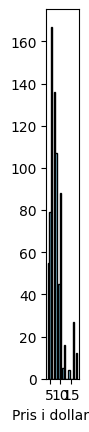

In [6]:
plt.hist(df2['Ages'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Pris i dollar [$]')
plt.ylabel('')
plt.gca().set_aspect(1)
plt.show()

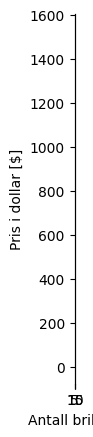

In [7]:
plt.scatter(df2['Ages'], df2['Pages'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

In [8]:
# hva er det dyreste settet i datasettet mon tro?
print(df2.loc[df2['Ages'].idxmax()])

Pieces    625.0
Pages     116.0
Ages       18.0
Name: 556, dtype: float64


In [9]:
# og hvilket har flest brikker?
print(df2.loc[df2['Pieces'].idxmax()])

Pieces    6020.0
Pages      636.0
Ages        16.0
Name: 821, dtype: float64


In [10]:
# hvilke tema har de billigste settene?
df2.groupby('Ages')['Pieces'].mean().sort_values(ascending=True)[:3]

Ages
5    137.291139
4    172.400000
6    187.497006
Name: Pieces, dtype: float64

In [11]:
# hvilke tema har flest brikker?
df2.groupby('Ages')['Pieces'].mean().sort_values(ascending=False)[:3]

Ages
11    2454.800000
16    2340.370370
18    1627.166667
Name: Pieces, dtype: float64

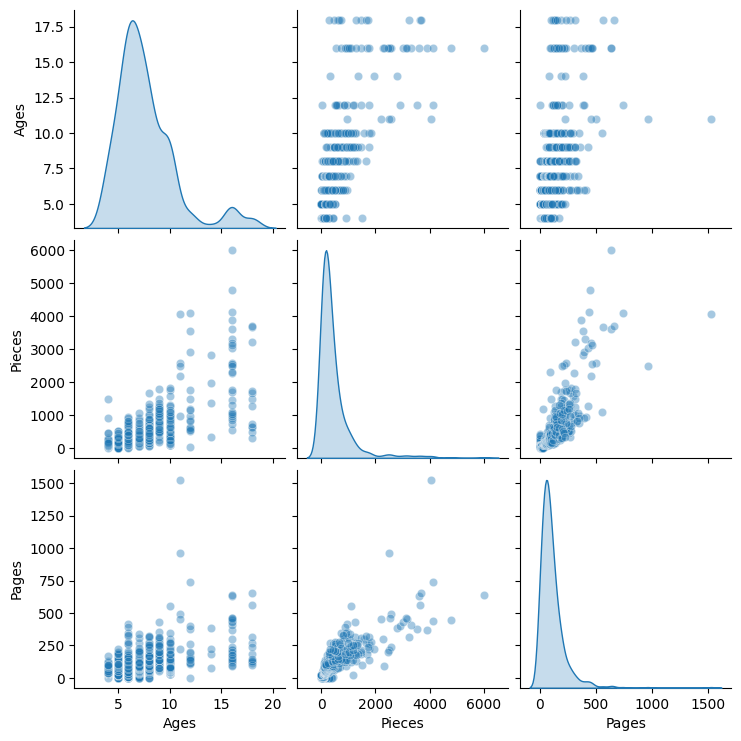

In [12]:
sns.pairplot(df2, vars = ['Ages', 'Pieces', 'Pages'],
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [13]:
# enkel lineær regresjon
formel = 'Pages ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Pages   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1468.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):          9.43e-178
Time:                        09:55:06   Log-Likelihood:                -4170.2
No. Observations:                 741   AIC:                             8344.
Df Residuals:                     739   BIC:                             8354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.8847      3.009     13.257      0.000      33.978      45.791
Pieces         0.1437      0.004     38.316      0.000       0.136       0.151
==============================================================================
Omnibus:                      742.228   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86467.841
Skew:                           4.210   Prob(JB):                         0.00
Kurtosis:                      55.246   Cond. No.                         975.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

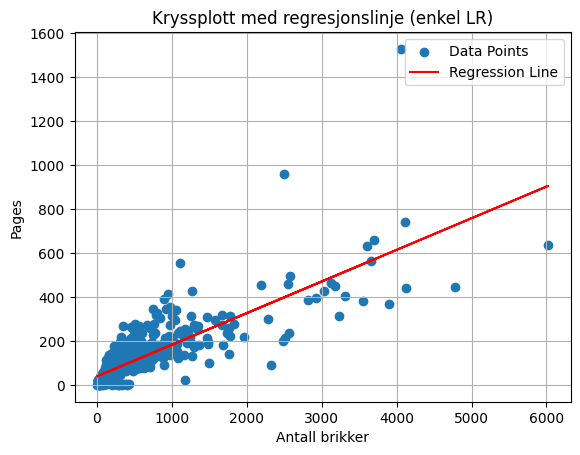

In [31]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Pages'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pages')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

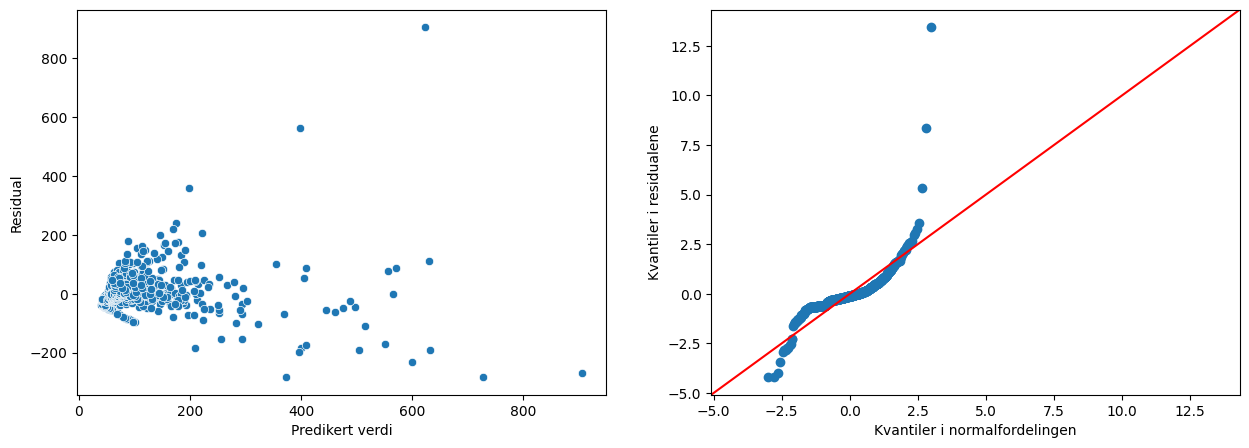

In [15]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

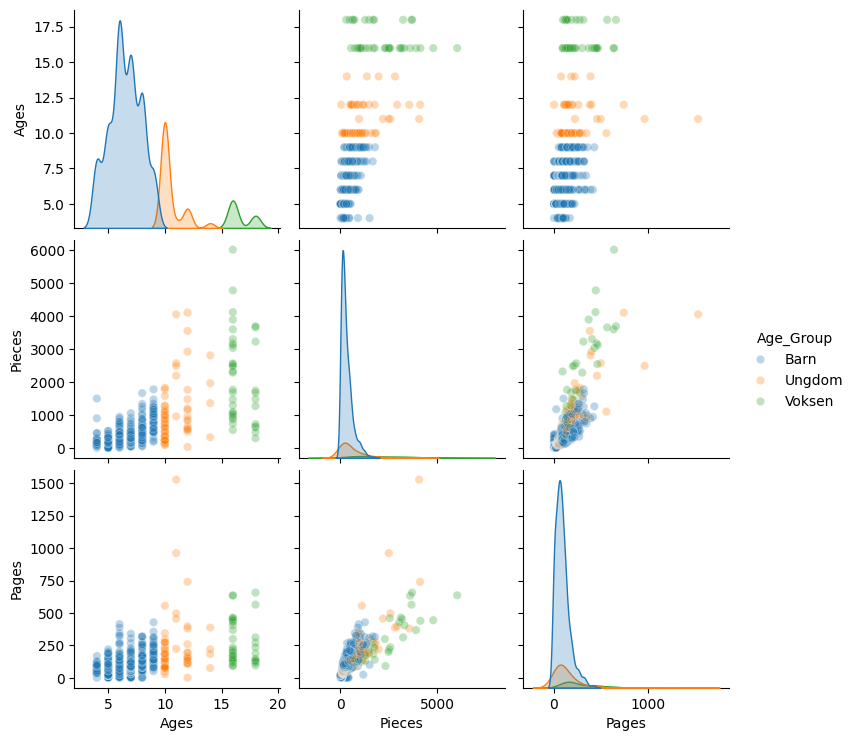

In [30]:
df3 = df2

age_groups = ['Barn', 'Ungdom', 'Voksen']

def calc_age_group(row):
    if row['Ages'] < 10:
        return age_groups[0]
    if row['Ages'] >= 10 and row['Ages'] < 15:
        return age_groups[1]
    if row['Ages'] >= 15:
        return age_groups[2]

df3 = df3.assign(Age_Group=df3.apply(calc_age_group, axis=1))

sns.pairplot(df3, vars = ['Ages', 'Pieces', 'Pages'],
             hue = 'Age_Group',
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.3))

In [17]:
# enkel lineær regresjon, tar ikke hensyn til tema
res_sub = smf.ols('Pages ~ Pieces' , data = df3).fit()

In [18]:
# enkel LR for hvert tema hver for seg
resultater = []
for i, group in enumerate(age_groups):
    modell3 = smf.ols('Pages ~ Pieces' , data = df3[df3['Age_Group'].isin([group])])
    resultater.append(modell3.fit())

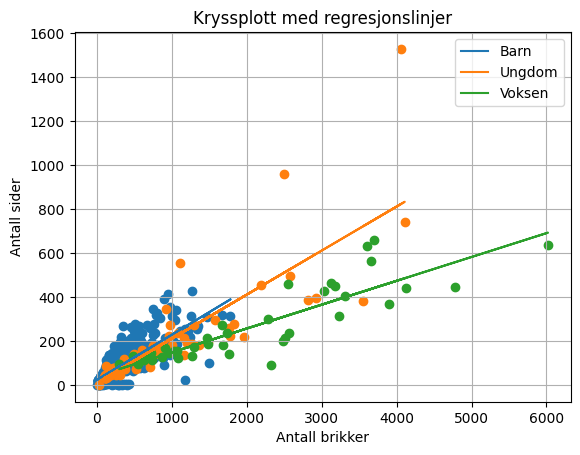

In [19]:
# plott av dataene og regresjonslinjene
for i, group in enumerate(age_groups):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(df3[df3['Age_Group'].isin([group])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(df3[df3['Age_Group'].isin([group])]['Pieces'], df3[df3['Age_Group'].isin([group])]['Pages'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=group)
    
plt.xlabel('Antall brikker')
plt.ylabel('Antall sider')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

## 

In [20]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Pages ~ Pieces + Age_Group' , data = df3)
modell3_mlr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Pages   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     574.0
Date:                Tue, 14 Nov 2023   Prob (F-statistic):          2.65e-192
Time:                        09:55:08   Log-Likelihood:                -4129.2
No. Observations:                 741   AIC:                             8266.
Df Residuals:                     737   BIC:                             8285.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              35.5275      2.979     11.928      0.000      29.680      41.375
Age_Group[T.Ungdom]    -3.6501      6.744     -0.541      0.588     -16.889       9.589
Age_Group[T.Voksen]  -122.7342     13.389     -9.167      0.000    -149.020     -96.449
Pieces                  0.1686      0.005     37.103      0.000       0.160       0.178
==============================================================================
Omnibus:                      667.747   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58363.811
Skew:                           3.599   Prob(JB):                         0.00
Kurtosis:                      45.878   Cond. No.                     4.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# multippel lineær regresjon med en annen referansekategori
# modell3_mlr_alt = smf.ols('Pages ~ Pieces + C(Age_Group, Treatment("Star Wars"))' , data = df3)
# modell3_mlr_alt.fit().summary()

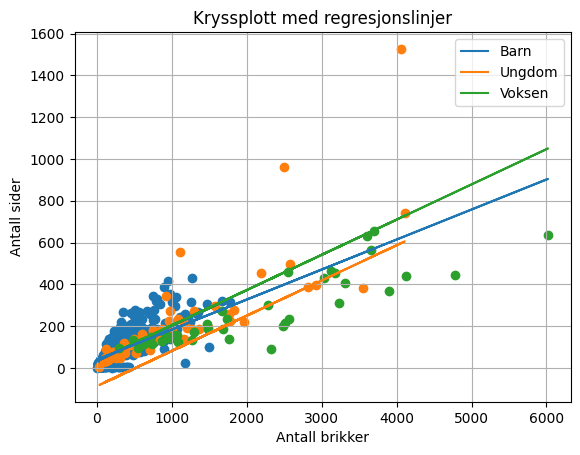

In [22]:
# plott

fitted_model = modell3_mlr.fit()

intercept = [fitted_model.params['Age_Group[T.Ungdom]'], fitted_model.params['Age_Group[T.Voksen]'], 0] + fitted_model.params['Intercept']
slope = modell3_mlr.fit().params['Pieces']

for i, group in enumerate(age_groups):

    regression_x = np.array(df3[df3['Age_Group'].isin([group])]['Pieces'])
    regression_y = slope * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(df3[df3['Age_Group'].isin([group])]['Pieces'], df3[df3['Age_Group'].isin([group])]['Pages'], color = plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=group)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(df3['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y)
    
plt.xlabel('Antall brikker')
plt.ylabel('Antall sider')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [23]:
# med interaksjonsledd mellom antall brikker og tema
modell3_mlri = smf.ols('Pages ~ Pieces * Age_Group' , data = df3)
modell3_mlri.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Pages   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     418.3
Date:                Tue, 14 Nov 2023   Prob (F-statistic):          3.52e-212
Time:                        09:55:08   Log-Likelihood:                -4076.6
No. Observations:                 741   AIC:                             8165.
Df Residuals:                     735   BIC:                             8193.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     24.3279      3.573      6.809      0.000      17.313      31.343
Age_Group[T.Ungdom]          -13.0316      7.990     -1.631      0.103     -28.718       2.655
Age_Group[T.Voksen]           16.3831     18.182      0.901      0.368     -19.312      52.078
Pieces                         0.2050      0.008     24.278      0.000       0.188       0.222
Pieces:Age_Group[T.Ungdom]    -0.0050      0.011     -0.464      0.643      -0.026       0.016
Pieces:Age_Group[T.Voksen]    -0.0967      0.011     -8.765      0.000      -0.118      -0.075
==============================================================================
Omnibus:                      576.811   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37610.001
Skew:                           2.909   Prob(JB):                         0.00
Kurtosis:                      37.414   Cond. No.                     7.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

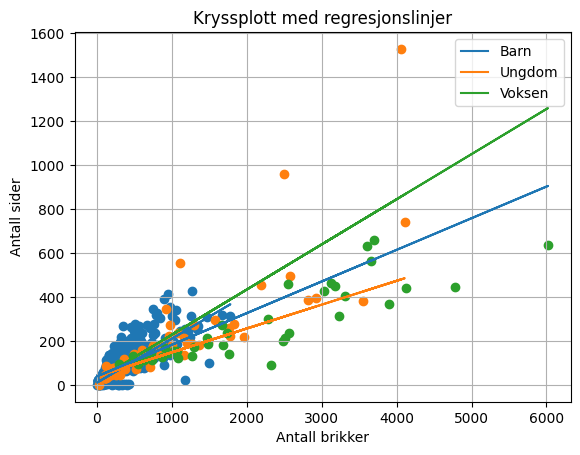

In [24]:
# plott
intercept = [modell3_mlri.fit().params['Age_Group[T.' + age_groups[1] + ']'], modell3_mlri.fit().params['Age_Group[T.' + age_groups[2] + ']'], 0] + modell3_mlri.fit().params['Intercept']
slope = [modell3_mlri.fit().params['Pieces:Age_Group[T.Ungdom]'], modell3_mlri.fit().params['Pieces:Age_Group[T.Voksen]'], 0] + modell3_mlri.fit().params['Pieces']

for i, group in enumerate(age_groups):

    regression_x = np.array(df3[df3['Age_Group'].isin([group])]['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(df3[df3['Age_Group'].isin([group])]['Pieces'], df3[df3['Age_Group'].isin([group])]['Pages'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=group)
    
# uten tema som forklaringsvariabel:
regression_x = np.array(df3['Pieces'])
regression_y = res_sub.params['Pieces'] * regression_x + res_sub.params['Intercept']
plt.plot(regression_x, regression_y)

plt.xlabel('Antall brikker')
plt.ylabel('Antall sider')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

In [25]:
# Kode for å lagre plot som (.png)
## fjern 'plt.show()' og erstatt med:
# plt.savefig('my_plot.png')

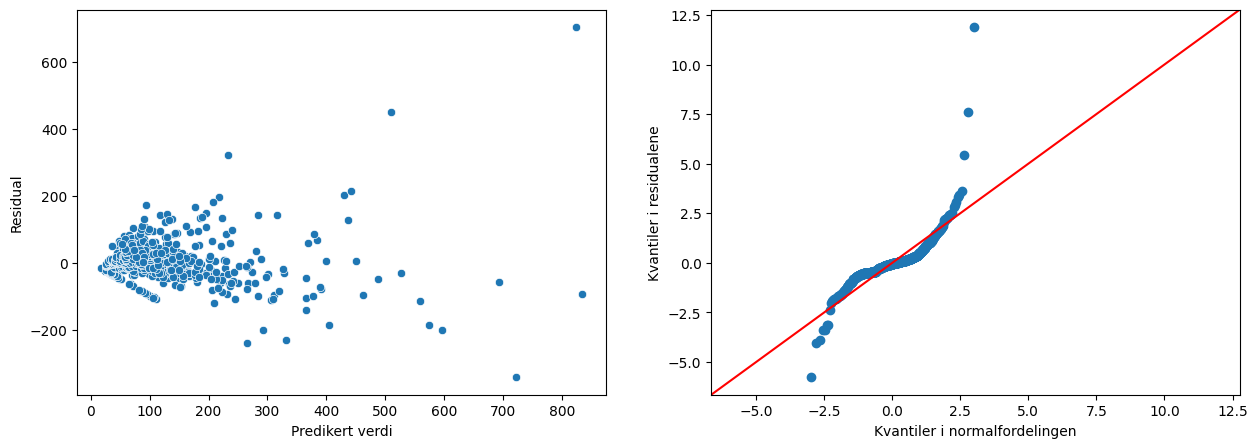

In [26]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlri.fit().fittedvalues, y = modell3_mlri.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlri.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

In [27]:
# Gruppere temaer i nye grupper:
# (Harry Potter, NINJAGO og Star Wars havner i én gruppe, City og Friends i en annen, og alle andre i en tredje)

# df2['cat'] = np.where(df2['Theme'].isin(['Harry Potter', 'NINJAGO', 'Star Wars']), 'Cat1', 
#                       np.where(df2['Theme'].isin(['City', 'Friends']), 'Cat2', 'Cat3'))
# df2.groupby(['cat']).size().reset_index(name = 'Count')

In [28]:
# df2.groupby(['cat', 'Theme']).size().reset_index(name = 'Count')